In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import glob

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import BinaryCrossentropy

import sklearn 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

import HigherTierModel
import PerformanceFuncs

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
#trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_*.npz')
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_shower.npz')
print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_shower.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

nEpochs = 10
batchSize = 64
learningRate = 1e-3

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 40))
variables_test = np.empty((0, 40))

# Truth
y_train = np.empty((0, 2))
y_test = np.empty((0, 2))
trueParentChildLink_train = np.empty((0), dtype='int')
trueParentChildLink_test = np.empty((0), dtype='int')

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)
    trueParentChildLink_train = np.concatenate((trueParentChildLink_train, data['trueParentChildLink_train']), axis=0)
    trueParentChildLink_test = np.concatenate((trueParentChildLink_test, data['trueParentChildLink_test']), axis=0)


Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_shower.npz , This may take a while...


In [5]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trueParentChildLink_train.shape:', trueParentChildLink_train.shape)
print('trueParentChildLink_test.shape:', trueParentChildLink_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

variables_train.shape: (734049, 40)
variables_test.shape: (81561, 40)
y_train.shape: (734049, 2)
y_test.shape: (81561, 2)
trueParentChildLink_train.shape: (734049,)
trueParentChildLink_test.shape: (81561,)


In [6]:
###########################################################
# Split it into two again
###########################################################

n_links = 2
n_global_vars = 6
n_link_vars = 17

i_end_of_global_vars = n_global_vars
i_target_start = variables_train.shape[1] - n_link_vars
i_rest_start = n_global_vars
i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))

# Training
input_0_train = variables_train
input_1_train = np.concatenate((input_0_train[:,0:i_end_of_global_vars], input_0_train[:,i_target_start:], input_0_train[:,i_rest_start:i_rest_end]), axis=1)

input_train = np.concatenate((input_0_train, input_1_train), axis=0)
truth_train = np.concatenate((y_train[:,0], y_train[:,1]), axis=0).reshape(-1,1)

# Test
input_0_test = variables_test
input_1_test = np.concatenate((input_0_test[:,0:i_end_of_global_vars], input_0_test[:,i_target_start:], input_0_test[:,i_rest_start:i_rest_end]), axis=1)

input_test = np.concatenate((input_0_test, input_1_test), axis=0)
truth_test = np.concatenate((y_test[:,0], y_test[:,1]), axis=0).reshape(-1,1)

In [7]:
###########################################################
# Check shapes
###########################################################

print('input_0_train:', input_0_train.shape)
print('input_1_train:', input_1_train.shape)
print('input_train:', input_train.shape)
print('truth_train:', truth_train.shape)

print('input_0_test:', input_0_test.shape)
print('input_1_test:', input_1_test.shape)
print('input_test:', input_test.shape)
print('truth_test:', truth_test.shape)

input_0_train: (734049, 40)
input_1_train: (734049, 40)
input_train: (1468098, 40)
truth_train: (1468098, 1)
input_0_test: (81561, 40)
input_1_test: (81561, 40)
input_test: (163122, 40)
truth_test: (163122, 1)


In [8]:
###########################################################
# Define class weights
###########################################################

nTrue = np.count_nonzero(truth_train == 1)
nWrongOrientation = np.count_nonzero(truth_train == 2)
nBackground = np.count_nonzero(truth_train == 0)
maxLinks = max(nTrue, nWrongOrientation, nBackground)

print('nTrue:', nTrue)
print('nWrongOrientation:', nWrongOrientation)
print('nBackground:', nBackground)

classWeights = {0: maxLinks/nBackground, 1: maxLinks/nTrue, 2: maxLinks/nWrongOrientation}

print('classWeights:', classWeights)

nTrue: 30612
nWrongOrientation: 30612
nBackground: 1406874
classWeights: {0: 1.0, 1: 45.958251666013325, 2: 45.958251666013325}


In [9]:
###########################################################
# Change format of truth labels
###########################################################

trueParentChildLink_train = trueParentChildLink_train.reshape(-1, 1)
trueParentChildLink_test = trueParentChildLink_test.reshape(-1, 1)

trueParentChildLink_train = to_categorical(trueParentChildLink_train, 2)
trueParentChildLink_test = to_categorical(trueParentChildLink_test, 2)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

truth_train = to_categorical(truth_train, 3)
truth_test = to_categorical(truth_test, 3)

In [10]:
###########################################################
# Define the model optimiser and compile the model
###########################################################

model = HigherTierModel.HigherTierModel(nVariables)
optimiser = optimizers.legacy.Adam(learning_rate=learningRate)
model.compile(optimizer=optimiser, metrics=['accuracy'], loss=['categorical_crossentropy'])


In [11]:
###########################################################
# Fit the model
###########################################################

filePath = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower'
    
# checkpoint
checkpoint = ModelCheckpoint(filePath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(input_train, truth_train, validation_data=(input_test, truth_test), 
                    batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list, class_weight=classWeights)

Epoch 1/10
22913/22940 [============================>.] - ETA: 0s - loss: 1.8287 - accuracy: 0.7298
Epoch 1: val_accuracy improved from -inf to 0.81224, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower/assets


22940/22940 [==============================] - 21s 915us/step - loss: 1.8283 - accuracy: 0.7299 - val_loss: 0.4976 - val_accuracy: 0.8122 - lr: 0.0010
Epoch 2/10
22896/22940 [============================>.] - ETA: 0s - loss: 1.5720 - accuracy: 0.7872
Epoch 2: val_accuracy did not improve from 0.81224
22940/22940 [==============================] - 20s 878us/step - loss: 1.5722 - accuracy: 0.7872 - val_loss: 0.5725 - val_accuracy: 0.7554 - lr: 0.0010
Epoch 3/10
22902/22940 [============================>.] - ETA: 0s - loss: 1.5167 - accuracy: 0.7978
Epoch 3: val_accuracy improved from 0.81224 to 0.81566, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower/assets


22940/22940 [==============================] - 24s 1ms/step - loss: 1.5165 - accuracy: 0.7977 - val_loss: 0.4758 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 4/10
22934/22940 [============================>.] - ETA: 0s - loss: 1.4871 - accuracy: 0.8017
Epoch 4: val_accuracy improved from 0.81566 to 0.82494, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower/assets


22940/22940 [==============================] - 25s 1ms/step - loss: 1.4871 - accuracy: 0.8017 - val_loss: 0.4768 - val_accuracy: 0.8249 - lr: 0.0010
Epoch 5/10
22934/22940 [============================>.] - ETA: 0s - loss: 1.4662 - accuracy: 0.8093
Epoch 5: val_accuracy did not improve from 0.82494

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
22940/22940 [==============================] - 33s 1ms/step - loss: 1.4661 - accuracy: 0.8093 - val_loss: 0.4816 - val_accuracy: 0.8101 - lr: 0.0010
Epoch 6/10
22916/22940 [============================>.] - ETA: 0s - loss: 1.3478 - accuracy: 0.8256
Epoch 6: val_accuracy improved from 0.82494 to 0.85304, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower/assets


22940/22940 [==============================] - 28s 1ms/step - loss: 1.3477 - accuracy: 0.8256 - val_loss: 0.4244 - val_accuracy: 0.8530 - lr: 1.0000e-04
Epoch 7/10
22909/22940 [============================>.] - ETA: 0s - loss: 1.3168 - accuracy: 0.8283
Epoch 7: val_accuracy did not improve from 0.85304
22940/22940 [==============================] - 29s 1ms/step - loss: 1.3165 - accuracy: 0.8283 - val_loss: 0.4354 - val_accuracy: 0.8405 - lr: 1.0000e-04
Epoch 8/10
22896/22940 [============================>.] - ETA: 0s - loss: 1.2999 - accuracy: 0.8299
Epoch 8: val_accuracy did not improve from 0.85304

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
22940/22940 [==============================] - 25s 1ms/step - loss: 1.3000 - accuracy: 0.8298 - val_loss: 0.4512 - val_accuracy: 0.8296 - lr: 1.0000e-04
Epoch 9/10
22922/22940 [============================>.] - ETA: 0s - loss: 1.2822 - accuracy: 0.8306
Epoch 9: val_accuracy did not improve from 0.85304
22940/2294

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


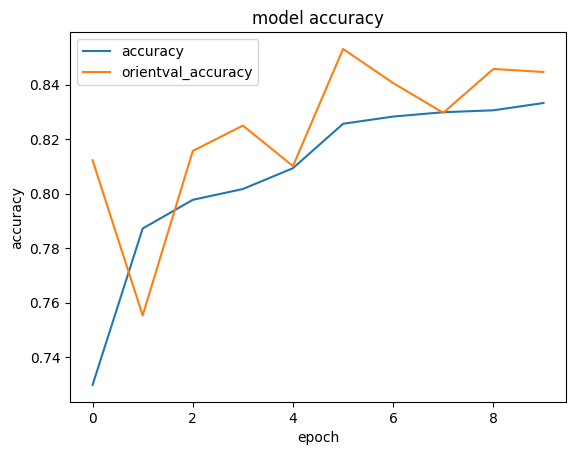

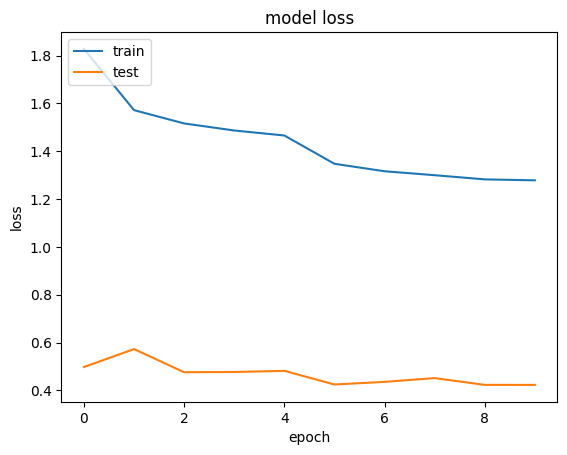

In [12]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'orientval_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_train = model.predict(input_train)
y_pred_test = model.predict(input_test)

5098/5098 [==============================] - 2s 340us/step


In [14]:
###########################################################
# Reshape the prediction for next network
###########################################################
y_pred_0_train = y_pred_train[0:ntrain].reshape(-1, 1, 3)
y_pred_1_train = y_pred_train[ntrain:(ntrain * 2)].reshape(-1, 1, 3)
input_final_train = np.concatenate((y_pred_0_train, y_pred_1_train), axis=1).reshape(-1, 6)

y_pred_0_test = y_pred_test[0:ntest].reshape(-1, 1, 3)
y_pred_1_test = y_pred_test[ntest:(ntest * 2)].reshape(-1, 1, 3)
input_final_test = np.concatenate((y_pred_0_test, y_pred_1_test), axis=1).reshape(-1, 6)

In [15]:
###########################################################
# Reshape the prediction and truth labels for metrics
###########################################################

pred_individual_links_train = input_final_train.reshape(-1, 3)
y_train = y_train.reshape(-1, 3)

pred_individual_links_test = input_final_test.reshape(-1, 3)
y_test = y_test.reshape(-1, 3)

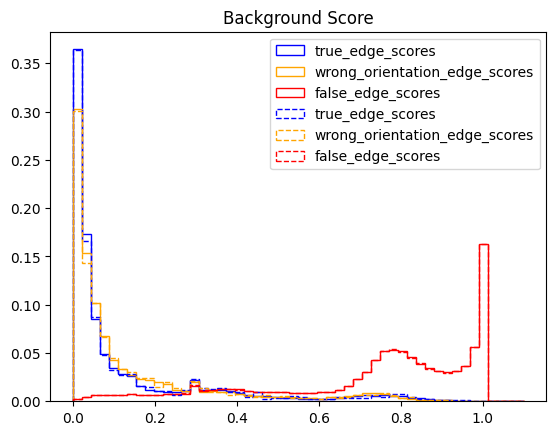

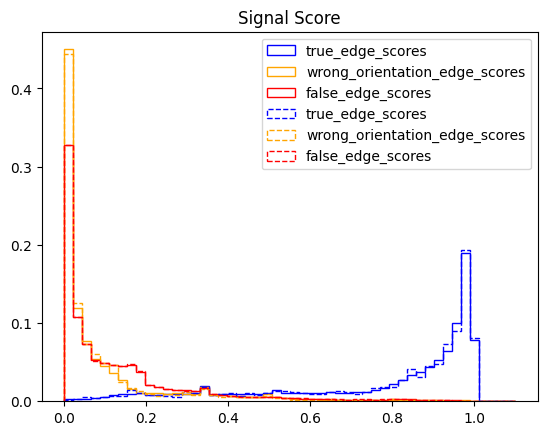

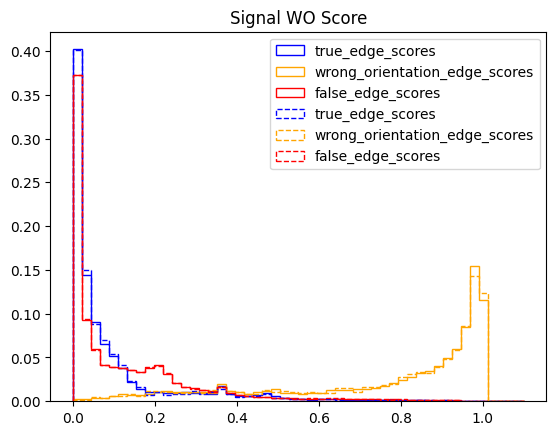

[[131878  12104  12144]
 [   341   2958    199]
 [   363    201   2934]]


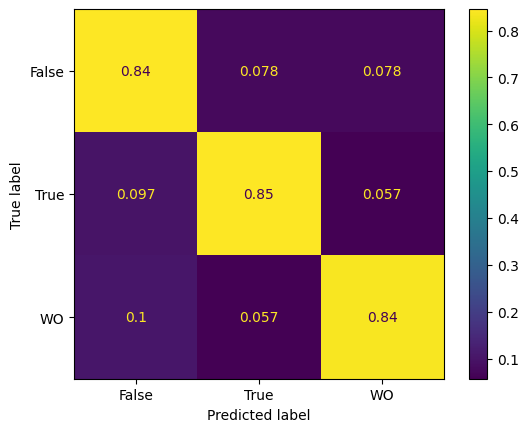

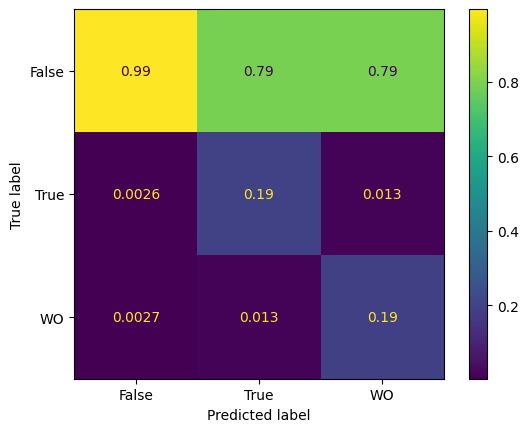

In [16]:
#######################################
# Plot edge scores
#######################################

PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 0)
PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 1)
PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 2)
PerformanceFuncs.draw_confusion_multi(pred_individual_links_test, y_test)

In [17]:
###########################################################
# Define the model and optimiser and compile the model
###########################################################

model_final = HigherTierModel.HigherTierFinalOutputModel(6, dropoutRate=0.5)
optimiser_final = optimizers.legacy.Adam(learning_rate=learningRate)
model_final.compile(optimizer=optimiser_final, metrics=['accuracy'], loss=['binary_crossentropy'])

In [18]:
###########################################################
# Define class weights
###########################################################

nTrue_final = np.count_nonzero(trueParentChildLink_train.argmax(axis=1) == 1)
nBackground_final = np.count_nonzero(trueParentChildLink_train.argmax(axis=1) == 0)

maxLinks = max(nTrue_final, nBackground_final)

classWeights_final = {0: maxLinks/nBackground_final, 1: maxLinks/nTrue_final}

print('classWeights_final:', classWeights_final)

classWeights_final: {0: 1.0, 1: 22.979125833006663}


In [19]:
###########################################################
# Reshape for sigmoid training
###########################################################

trueParentChildLink_train = trueParentChildLink_train.argmax(axis=1).reshape((-1,1))
trueParentChildLink_test = trueParentChildLink_test.argmax(axis=1).reshape((-1,1))

In [20]:
###########################################################
# Fit the model
###########################################################

filePath_final = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_shower'
    
# checkpoint
checkpoint_final = ModelCheckpoint(filePath_final, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list_final = [checkpoint_final, reduce_lr_final]

history_final = model_final.fit(input_final_train, trueParentChildLink_train, validation_data=(input_final_test, trueParentChildLink_test), 
                          batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list_final, class_weight=classWeights_final)

Epoch 1/10
11463/11470 [============================>.] - ETA: 0s - loss: 0.6229 - accuracy: 0.8560
Epoch 1: val_accuracy improved from -inf to 0.84825, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_shower/assets


11470/11470 [==============================] - 5s 463us/step - loss: 0.6228 - accuracy: 0.8560 - val_loss: 0.3076 - val_accuracy: 0.8482 - lr: 0.0010
Epoch 2/10
11465/11470 [============================>.] - ETA: 0s - loss: 0.5756 - accuracy: 0.8528
Epoch 2: val_accuracy improved from 0.84825 to 0.85498, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_shower/assets


11470/11470 [==============================] - 5s 463us/step - loss: 0.5757 - accuracy: 0.8528 - val_loss: 0.2929 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 3/10
11439/11470 [============================>.] - ETA: 0s - loss: 0.5753 - accuracy: 0.8535
Epoch 3: val_accuracy did not improve from 0.85498
11470/11470 [==============================] - 5s 472us/step - loss: 0.5756 - accuracy: 0.8535 - val_loss: 0.3011 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 4/10
11402/11470 [============================>.] - ETA: 0s - loss: 0.5757 - accuracy: 0.8532
Epoch 4: val_accuracy did not improve from 0.85498

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
11470/11470 [==============================] - 5s 434us/step - loss: 0.5755 - accuracy: 0.8532 - val_loss: 0.3000 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 5/10
11359/11470 [============================>.] - ETA: 0s - loss: 0.5756 - accuracy: 0.8540
Epoch 5: val_accuracy did not improve from 0.85498
11470/11470 [======

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


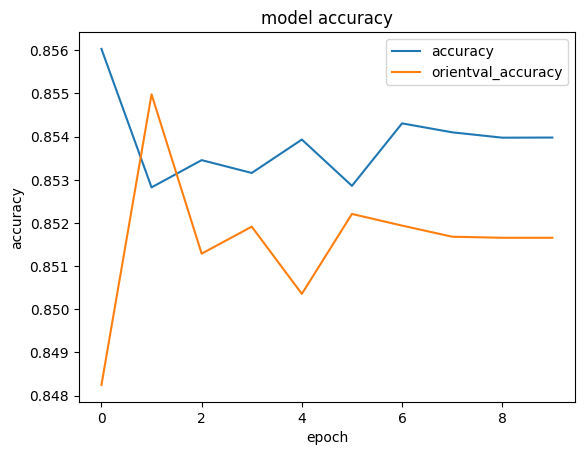

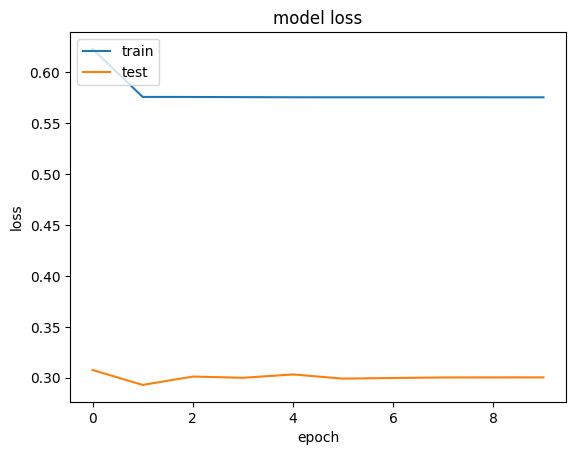

In [21]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history_final.history.keys())

# summarize history for accuracy
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'orientval_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_final_train = model_final.predict(input_final_train)
y_pred_final_test = model_final.predict(input_final_test)

2549/2549 [==============================] - 4s 2ms/step


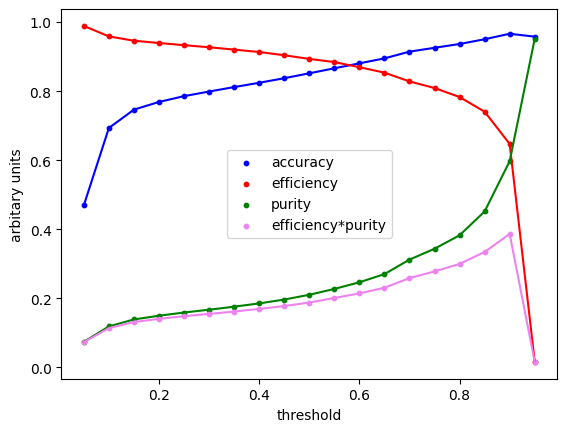

optimal_threshold_metric: 0.9000000000000001


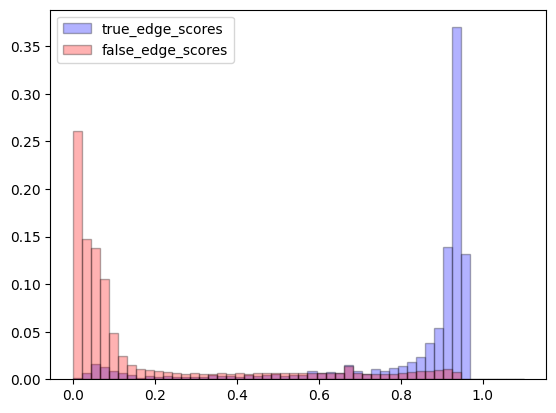

[[66337 11726]
 [  373  3125]]
[[76536  1527]
 [ 1234  2264]]


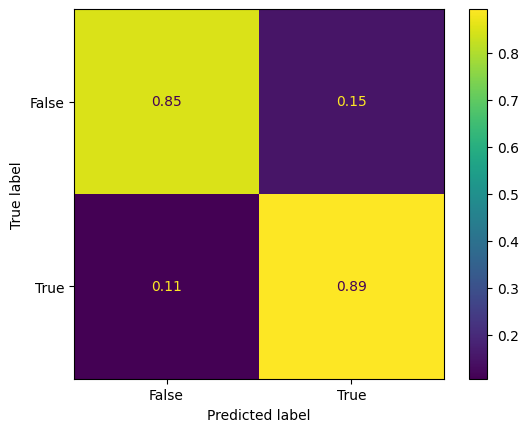

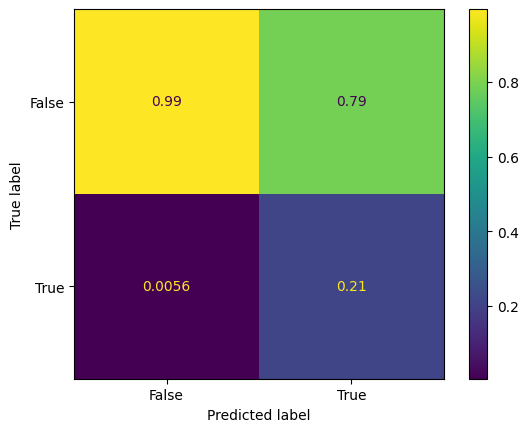

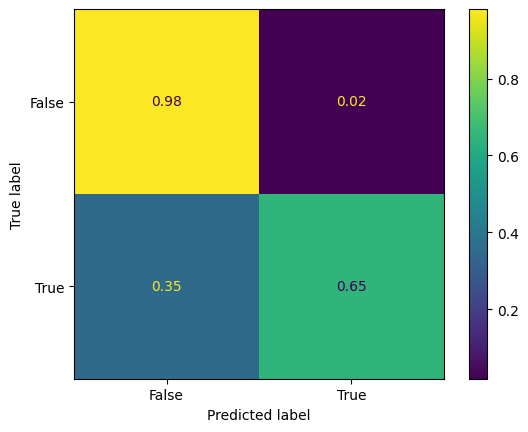

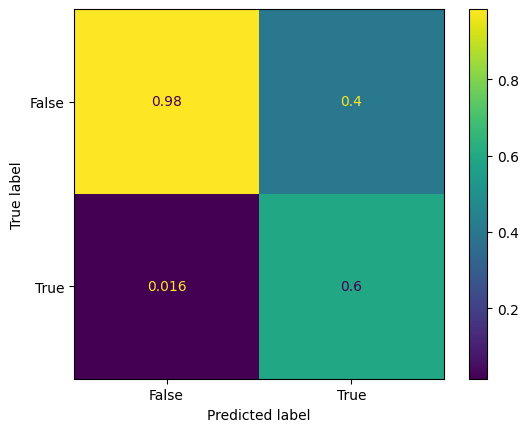

In [23]:
#######################################
# Plot final link prediction
#######################################

optimal_threshold, max_accuracy, optimal_threshold_metric, max_metric = PerformanceFuncs.calculate_accuracy(y_pred_final_test, trueParentChildLink_test)

print('optimal_threshold_metric:', optimal_threshold_metric)

PerformanceFuncs.plot_scores(y_pred_final_test, trueParentChildLink_test)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, trueParentChildLink_test, 0.5)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, trueParentChildLink_test, optimal_threshold_metric)
